<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Final_Downtown_LA_Traffic_Prediction_I110_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
controller_data_test = pd.read_csv('Combined flows test.csv')
controller_data_test.dropna(how='all', inplace=True)

controller_data_train = pd.read_csv('Combined flows train.csv')
controller_data_train.dropna(how='all', inplace=True)

In [ ]:
controller_data_train["5 Minutes"] = pd.to_datetime(controller_data_train["5 Minutes"])
controller_data_train.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow_train = controller_data_train[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]

controller_data_test["5 Minutes"] = pd.to_datetime(controller_data_test["5 Minutes"])
controller_data_test.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow_test = controller_data_test[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]

                     MADOR Flow (Veh/5 Minutes)  THIRD Flow (Veh/5 Minutes)  \
5 Minutes                                                                     
2018-06-04 00:00:00                         116                         179   
2018-06-04 00:05:00                         119                         168   
2018-06-04 00:10:00                          88                         141   
2018-06-04 00:15:00                          81                         130   
2018-06-04 00:20:00                          84                         166   
...                                         ...                         ...   
2018-07-01 23:35:00                         153                         143   
2018-07-01 23:40:00                         152                         139   
2018-07-01 23:45:00                         139                         136   
2018-07-01 23:50:00                         149                         132   
2018-07-01 23:55:00                         136     

In [ ]:
# Normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
flow_train = scaler.fit_transform(time_flow_train)
flow_test = scaler.transform(time_flow_test)

In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(flow_train, look_back)
X_test, y_test = create_dataset(flow_test, look_back)


# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [ ]:
from keras import layers

class StoreWeightsCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.weights_history = []  # List to store weights after each epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_weights = {}  # Dictionary to store weights for this epoch
        for layer in self.model.layers:
            if hasattr(layer, 'weights') and layer.weights:
                epoch_weights[layer.name] = [w.numpy() for w in layer.weights]

        self.weights_history.append(epoch_weights)

In [ ]:
# Define the model builder function
def build_model(hp):
    input_layer = keras.layers.Input(shape=(look_back, 5))

    # Determine the number of hidden layers (between 2 and 5)
    num_layers = hp.Int("num_layers", min_value=2, max_value=5, step=1)

    # First LSTM layer
    x = layers.LSTM(hp.Choice("units_1", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
                     activation='tanh', return_sequences=True)(input_layer)

    # Additional LSTM layers
    for i in range(2, num_layers + 1):
        return_sequences = i != num_layers  # Only the last encoding layer should return False
        x = layers.LSTM(hp.Choice(f"units_{i}", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
                         activation='tanh', return_sequences=return_sequences)(x)

    # Decoder
    decoded = layers.RepeatVector(look_back)(x)
    for i in range(num_layers, 0, -1):
        decoded = layers.LSTM(hp.Choice(f"units_d{i}", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]),
                               activation='tanh', return_sequences=True)(decoded)
    decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(decoded)

    autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

    # Compile model
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])),
                        loss='mse')

    return autoencoder


# Keras Tuner - Hyperband for tuning
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=30,
    directory='kt_lstm_autoencoder',
    project_name='traffic_prediction'
)

# Run the tuner
tuner.search(X_train, X_train, epochs=20, validation_data=(X_test, X_test))

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Print best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(1, best_hps.get('num_layers')):
    print(f"Layer {i+1} Units: {best_hps.get(f'units_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Dropout Rate: {best_hps.get('dropout')}")

# Callback to store best model weights
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_weights.h5',  # File to save the best model weights
    save_weights_only=True,  # Save only weights, not the entire model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save when val_loss decreases
    save_best_only=True,  # Save only the best weights
    verbose=1  # Print saving info
)

# Train best model
store_weights = StoreWeightsCallback()

train = best_model.fit(X_train, X_train, epochs=80, validation_data=(X_test, X_test), callbacks = [store_weights])


Trial 30 Complete [00h 10m 55s]
val_loss: 0.009923855774104595

Best val_loss So Far: 0.009781865403056145
Total elapsed time: 03h 46m 42s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
Number of Layers: 4


KeyError: 'units_0 does not exist.'

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Choice)
{'default': 100, 'conditions': [], 'values': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'ordered': True}
units_2 (Choice)
{'default': 100, 'conditions': [], 'values': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'ordered': True}
units_d2 (Choice)
{'default': 100, 'conditions': [], 'values': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'ordered': True}
units_d1 (Choice)
{'default': 100, 'conditions': [], 'values': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
units_3 (Choice)
{'default': 100, 'conditions': [], 'values': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'ordered': True}
units_4 (Choice)
{'default': 100, 'conditions': [], 'value

In [ ]:
# Print best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(1, best_hps.get('num_layers')):
    print(f"Layer {i+1} Units: {best_hps.get(f'units_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
Number of Layers: 4
Layer 2 Units: 100
Layer 3 Units: 700
Layer 4 Units: 300
Learning Rate: 0.001


In [ ]:
# Callback to store best model weights
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.weights.h5',  # File to save the best model weights
    save_weights_only=True,  # Save only weights, not the entire model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save when val_loss decreases
    save_best_only=True,  # Save only the best weights
    verbose=1  # Print saving info
)

In [ ]:
# Train best model
store_weights = StoreWeightsCallback()

train = best_model.fit(X_train, X_train, epochs=40, validation_data=(X_test, X_test), callbacks = [store_weights])

Epoch 1/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0077 - val_loss: 0.0098
Epoch 2/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0076 - val_loss: 0.0098
Epoch 3/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 4/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 5/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 6/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 7/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 8/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 9/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 10/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 11/40
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 12/40
567/567 ━━━━━━━━━━

In [ ]:
best_model.save_weights('/content/best_model.weights.h5')


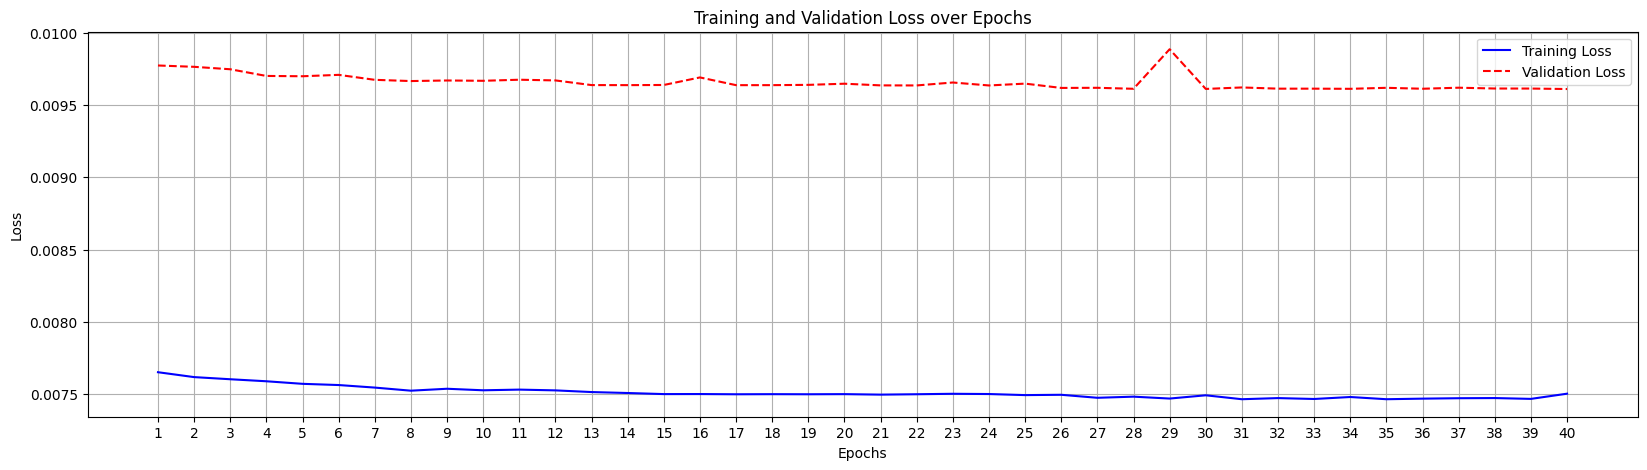

In [ ]:
# Function to plot loss over epochs
def plot_loss(history):
    plt.figure(figsize=(20, 5))
    epochs = range(1, len(history.history['loss']) + 1)  # Start from 1 instead of 0
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed')
    plt.xticks(epochs)  # This ensures every epoch is labeled
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train)

In [ ]:
len(store_weights.weights_history)

80

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=(look_back, 5), outputs=best_model.x)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

AttributeError: 'Functional' object has no attribute 'x'

In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(5, activation='linear'))



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0318 - val_loss: 0.0055
Epoch 2/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 3/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 4/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 5/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 6/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 7/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 9/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 10/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 11/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 12/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.

In [ ]:
prediction_model.summary()


NameError: name 'prediction_model' is not defined

In [ ]:
# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_test, y_test))

In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_test)

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_pred

array([[0.10113463, 0.15509151, 0.17716452, 0.12946214, 0.13407682],
       [0.09480281, 0.15030172, 0.17834735, 0.12872052, 0.13630483],
       [0.09142338, 0.13902378, 0.17274138, 0.12406215, 0.1292106 ],
       ...,
       [0.20741649, 0.2796582 , 0.42391956, 0.37974906, 0.31156418],
       [0.18998593, 0.2650766 , 0.4111215 , 0.36375526, 0.29891962],
       [0.17843105, 0.2468397 , 0.3908278 , 0.34749964, 0.28183448]],
      dtype=float32)

In [ ]:
# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
y_pred_rescaled

array([[ 61.388718, 110.13843 , 216.14114 , 133.34601 , 171.74721 ],
       [ 57.545307, 108.126724, 216.9833  , 132.58214 , 173.98636 ],
       [ 55.49399 , 103.389984, 212.99187 , 127.78401 , 166.85666 ],
       ...,
       [125.90181 , 162.45645 , 391.83075 , 391.14154 , 350.12198 ],
       [115.32146 , 156.33218 , 382.7185  , 374.6679  , 337.4142  ],
       [108.30765 , 148.67268 , 368.2694  , 357.92462 , 320.24365 ]],
      dtype=float32)

In [ ]:
import numpy as np

# Define evaluation metric functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Function to evaluate model performance
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mre = mean_relative_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Relative Error (MRE): {mre:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Example Usage:
# Replace y_test and y_pred with actual test labels and predictions
# y_test = np.array([...])  # Actual traffic flow values
# y_pred = np.array([...])  # Predicted traffic flow values
evaluate_model(np.array(y_test_rescaled), np.array(y_pred_rescaled))


Mean Absolute Error (MAE): 29.9205
Mean Relative Error (MRE): 8.8990%
Root Mean Squared Error (RMSE): 41.2777


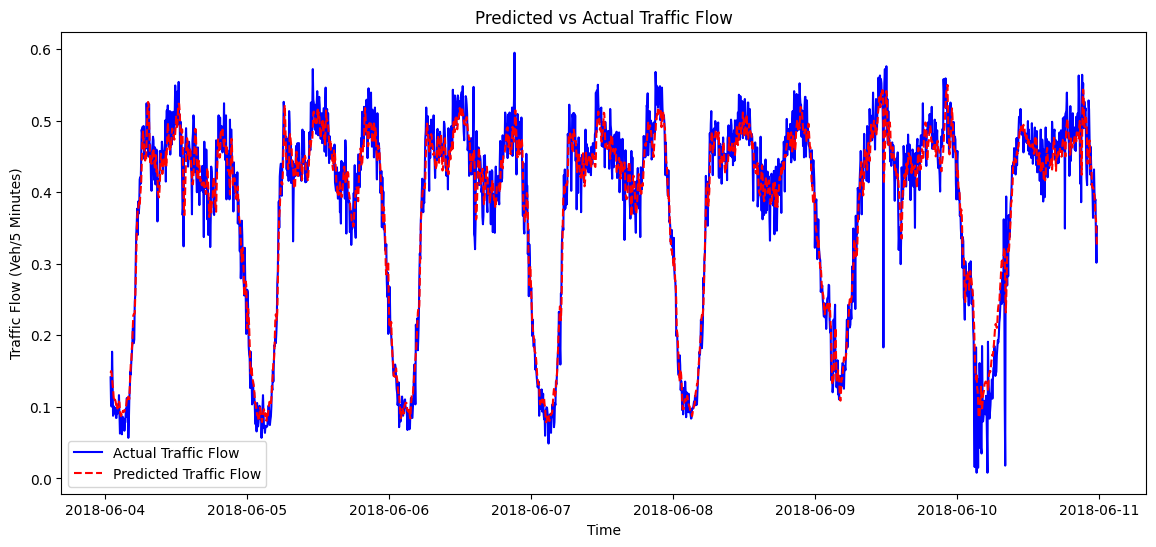

In [ ]:
# timestamps from validation set.
timestamps = time_flow_test.index[-len(y_test):]


# 287 timestamps in 1 day


plt.figure(figsize=(14, 6))
plt.plot(timestamps[:2000], y_test[:2000, -1], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps[:2000], y_pred[:2000, -1], label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()
